<a href="https://colab.research.google.com/github/Svensone/kaggle/blob/main/2021_03_29_%5BfastaiV2%5D_CV_Pneumonia_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Computer Vision with Fastai/Pytorch

## **Detection of Pneumonia in lung scans**

## 1. Setup

##############################

In [ ]:
# Test this 

# https://www.kaggle.com/svensone/fastaiv2-cv-melanoma-dicom/edit

In [ ]:
# update fastai to Version 2.0
!pip install fastai --upgrade

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# import necessary libaries

#basics
import pandas as pd
import numpy as np
import random, os

# ML
import fastai
from fastai.vision.all import *
import torch

# Data Exploration / Visualization
import seaborn as sns

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

#check versions
print('Numpy        :', np.__version__)
print('fastai      :', fastai.__version__)

Numpy        : 1.19.5
fastai      : 2.2.7


In [ ]:
## for reproducability set seed
def seed_everything(seed=0):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Connect to kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"svensone","key":"a6d65a12358897f43d36dd282a344f9e"}'}

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 64 Mar 29 21:27 kaggle.json


In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

2. Data

2.1 Data from Kaggle
2.2 Data from github https://github.com/ieee8023/covid-chestxray-dataset

*   List item
*   List item



In [ ]:
# List available datasets and download data

## Already downloaded - Skip
# !kaggle datasets list 

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              221KB  2021-03-29 08:29:47           1233  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            920  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            762  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            338  
alsgroup/end-als                                            End ALS Kaggle C

In [ ]:
!pwd

/content


In [ ]:
# change working dir to colab/pneumonia dir
%cd drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData
!pwd

/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData
/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData


In [ ]:
!ls 

'2021.03.29 [fastaiV2] CV-mulitDatasets Pneumonia Kaggle.ipynb'
 app.py
 chest_xray
 covid_xray
'[fastAI] Pneumonia Ngrok-Streamlit.ipynb'
 test_images


## 2. Data Loading & Exploration

###############################


### 2.1 Get the data

run code only **once**


In [ ]:
# only once - uncomment
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:33<00:00, 102MB/s] 
100% 2.29G/2.29G [00:33<00:00, 72.6MB/s]


In [ ]:
# !unzip -q chest-xray-pneumonia.zip

In [ ]:
# !kaggle datasets list -s covid-19

ref                                                title                                                size  lastUpdated          downloadCount  
-------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
imdevskp/corona-virus-report                       COVID-19 Dataset                                     19MB  2020-08-07 03:47:47         128248  
sudalairajkumar/covid19-in-india                   COVID-19 in India                                   199KB  2020-12-09 06:18:02          95624  
allen-institute-for-ai/CORD-19-research-challenge  COVID-19 Open Research Dataset Challenge (CORD-19)    8GB  2021-03-09 14:24:18         119372  
roche-data-science-coalition/uncover               UNCOVER COVID-19 Challenge                          256MB  2020-08-10 14:53:45          19750  
gpreda/covid-world-vaccination-progress            COVID-19 World Vaccination Progress                 140KB  2021-03-

In [ ]:
# !makedir covid_chest_xray
# !kaggle datasets download bachrr/covid-chest-xray -p'/covid_chest_xray'

/bin/bash: makedir: command not found
100% 241M/241M [00:03<00:00, 66.4MB/s]



In [ ]:
# !unzip -q "/covid_chest_xray/covid-chest-xray.zip"

### 1.2 Take a look

In [ ]:
# Paths
path_covid = Path("/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/covid_xray")
path_pneumonia = Path("/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/chest_xray")


In [ ]:
df_covid = pd.read_csv(path_covid/'metadata.csv')
df_covid.head()

In [ ]:
df_covid.describe()
df_covid.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2',
       'extubated', 'temperature', 'pO2_saturation', 'leukocyte_count',
       'neutrophil_count', 'lymphocyte_count', 'view', 'modality', 'date',
       'location', 'folder', 'filename', 'doi', 'url', 'license',
       'clinical_notes', 'other_notes', 'Unnamed: 28'],
      dtype='object')

In [ ]:
path_covid = Path("/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/covid_xray")
path_pneumonia = Path("/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/chest_xray")

path_train = path_pneumonia/"chest_xray/train"
path_train_normal = path_train/"NORMAL"
path_train_pneumonia = path_train/"PNEUMONIA"

print(len(path_train_normal.ls()), len(path_train_pneumonia.ls()))


1342 3876


In [ ]:
path_test_normal = path_pneumonia/'chest_xray/test/NORMAL'
path_test_pneumonia = path_pneumonia/'chest_xray/test/PNEUMONIA'
print(len(path_test_normal.ls()), len(path_test_pneumonia.ls()))
# path_pneumonia

234 390


In [ ]:
# # combining 2 Dataset
# Option 1. copy/paste folders together (3 folders(normal, pneum and covid))
# Option 2 with .add(ImageList) then only (normal/pneumonia as classes possible)
# src_combined = (ImageList.from_folder(path_data).add(ImageList.from_folder(path/'test-jpg-additional')))

## 2. Data Preprocessing / Augmentation

##############################

In [ ]:
# create Data with DataBlock Api (ImageDataBunch also possible but inflexible)
data_path = path_pneumonia/'chest_xray'

dls = ImageDataLoaders.from_folder(
    data_path, train='train', 
    valid_pct=0.2, 
    item_tfms=Resize(224), 
    bs = 64, 
    seed=0)

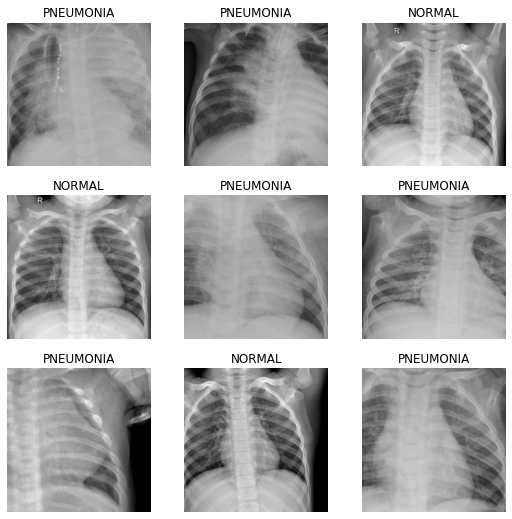

In [ ]:
dls.show_batch()

## 4. CNN Model

#########################

- Training and Fine_tuning
- interpretation and results




### 4.1 Training

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.005248074419796467)

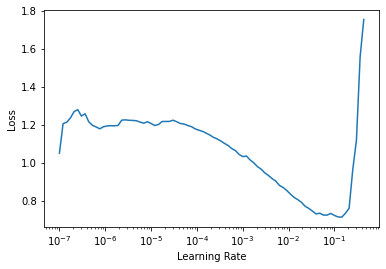

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_max=1e-2 , cbs=EarlyStoppingCallback(patience=3))


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.325853,0.617195,0.263877,0.736123,03:59
1,0.210156,1.039873,0.258753,0.741247,01:31
2,0.149127,1.078685,0.259607,0.740393,01:30
3,0.092791,1.295602,0.260461,0.739539,01:30


No improvement since epoch 0: early stopping


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, lr_max= 1e-4, cbs=EarlyStoppingCallback(patience=3))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.083296,1.480528,0.259607,0.740393,01:33
1,0.068195,2.109633,0.259607,0.740393,01:33
2,0.045077,2.082513,0.259607,0.740393,01:33
3,0.028180,2.062042,0.259607,0.740393,01:33


No improvement since epoch 0: early stopping


In [ ]:
learn.save('resent34_stage_1')

Path('/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/chest_xray/chest_xray/models/resent34_stage_1.pth')

### 4.2 Evaluation

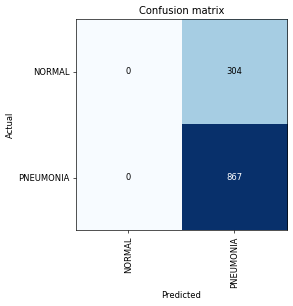

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

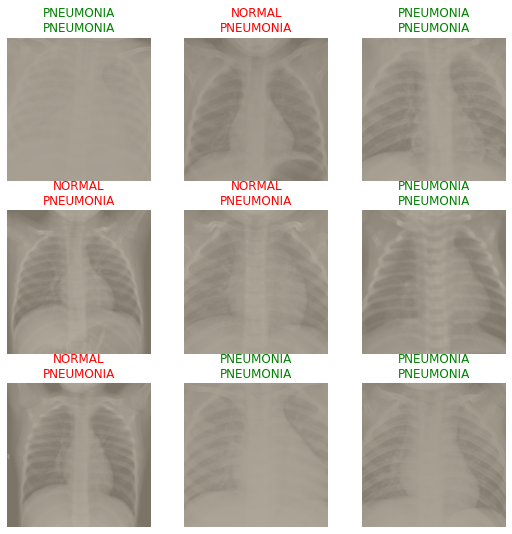

In [ ]:
learn.show_results()

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.121570,4.917150,0.385141,0.614859,01:32
1,0.138863,1.454223,0.259607,0.740393,01:32
2,0.121171,1.953449,0.259607,0.740393,01:32
3,0.082200,1.551301,0.259607,0.740393,01:32
4,0.051980,1.439324,0.259607,0.740393,01:32


In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.046111,1.278586,0.259607,0.740393,01:31


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.038187,1.459890,0.259607,0.740393,01:32
1,0.037559,1.500762,0.259607,0.740393,01:33
2,0.030354,1.898552,0.259607,0.740393,01:32
3,0.023444,2.082859,0.259607,0.740393,01:33
4,0.017566,2.161468,0.259607,0.740393,01:32


## 5. Prediction

#####################

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.load('/content/drive/MyDrive/Colab Notebooks/fastai_pneumonia_KaggleData/chest_xray/chest_xray/models/resent34_stage_2')

In [ ]:
preds, _ = learn.get_preds()
preds.shape

torch.Size([1171, 2])

In [ ]:
test_items = get_image_files(path_pneumonia/'chest_xray/test')
dl_test = learn.dls.test_dl(test_items, rm_type_tfms=1, bs=64)

In [ ]:
y_pred, _ = learn.get_preds(dl=dl_test)
thresh = 0.5
yhat_test = [' '.join([learn.dls.vocab[i] for i,p in enumerate(pred) if p > thresh]) for pred in y_pred.numpy()]

In [ ]:
y_test = list(map(lambda x: x.parents[0].name, test_items))

In [ ]:
results = pd.DataFrame({'target': y_test, 'pred': yhat_test})

accuracy1 = results[results.target == results.pred].shape[0]

accuracy = accuracy1 / results.shape[0]
accuracy


0.6057692307692307

## 5. Export

In [ ]:
learn.export('resnet34_stage_2.pkl')

# Notes
#######################

2021 April:
- train more with bigger img size Resize()
- calculate Sensitivity / Specificity

2021 March (Accuracy 74%, 14 epochs)
- Model and Training on Colab
- deployed on share.streamlit.io
- colab & streamlit - ngrok (only working when colab notebook running in background - see notebook) - deploy
- medical images : https://docs.fast.ai/tutorial.medical_imaging.html

2021.03.13 :
- refactor for Fastai Version 2

2020 Juni (fastai V1, accuracy= 97% (only pneumonia img))
- 20.06.2020 moved to Colab since no GPU in Kaggle
- 23.06 ResNet34: accuracy= 97% (only pneumonia img)
- 23.06 adding covid data
    - new branch
    - new File (in Kaggle dir) for joining Datasets 
